In [47]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
from torchvision import models
from torchsummary import summary
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
from matplotlib import pyplot as plt

# Загрузка данных

In [48]:
PATH = os.getcwd()
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS_NUMBER = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
loss_function = torch.nn.CrossEntropyLoss()
RESNET_50_MODEL_NAME = "ResNet50"
SWIN_V2_MODEL_NAME = "SwinV2"
GOOGLENET_MODEL_NAME = "GoogLeNet"
SHUFFLENET_V2_MODEL_NAME = "ShuffleNet_V2"
model_names = (RESNET_50_MODEL_NAME, SWIN_V2_MODEL_NAME, GOOGLENET_MODEL_NAME, SHUFFLENET_V2_MODEL_NAME)

Using device: cuda


In [49]:
def get_datasets(model_name):
  model_transforms = None
  if (model_name == RESNET_50_MODEL_NAME):
    model_transforms = models.ResNet50_Weights.DEFAULT.transforms()
  elif (model_name == SWIN_V2_MODEL_NAME):
    model_transforms = models.Swin_V2_T_Weights.DEFAULT.transforms()
  elif (model_name == GOOGLENET_MODEL_NAME):
    model_tranforms = models.GoogLeNet_Weights.DEFAULT.transforms()
  elif (model_name == SHUFFLENET_V2_MODEL_NAME):
    model_tranfroms = models.ShuffleNet_V2_X2_0_Weights.DEFAULT.transforms()
  else:
    raise ValueError(f"Model name {model_name} is not supported")

  train_dataset = torchvision.datasets.CIFAR10(
      root = PATH, train = True, download = True,
      transform = model_transforms
  )

  test_dataset = torchvision.datasets.CIFAR10(
      root = PATH, train = False, download = True,
      transform = model_transforms
  )

  return train_dataset, test_dataset


def get_dataset_loaders(train_dataset, test_dataset):
    train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size = BATCH_SIZE, shuffle = True
      )
    test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size = BATCH_SIZE, shuffle = False
      )
    return train_data_loader, test_data_loader

In [50]:
resnet_train_dataset, resnet_test_dataset = get_datasets(RESNET_50_MODEL_NAME)
resnet_train_data_loader, resnet_test_data_loader = get_dataset_loaders(resnet_train_dataset, resnet_test_dataset)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
swin_train_dataset, swin_test_dataset = get_datasets(SWIN_V2_MODEL_NAME)
swin_train_data_loader, swin_test_data_loader = get_dataset_loaders(swin_train_dataset, swin_test_dataset)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
googlenet_train_dataset, googlenet_test_dataset = get_datasets(GOOGLENET_MODEL_NAME)
googlenet_train_data_loader, googlenet_test_data_loader = get_dataset_loaders(googlenet_train_dataset, googlenet_test_dataset)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
shufflenet_train_dataset, shufflenet_test_dataset = get_datasets(SHUFFLENET_V2_MODEL_NAME)
shufflenet_train_data_loader, shufflenet_test_data_loader = get_dataset_loaders(shufflenet_train_dataset, shufflenet_test_dataset)

Files already downloaded and verified
Files already downloaded and verified


# Построение архитектуры сверточной сети

In [54]:
def create_first_model_config(model, weights, is_swin_model=False):
  cnn_model = model(weights)

  for params in cnn_model.parameters():
    params.requires_grad = False

  if not is_swin_model:
    input_layers = cnn_model.fc.in_features
    cnn_model.fc = torch.nn.Linear(input_layers, 10)
  else:
    input_layers = cnn_model.head.in_features
    cnn_model.head = torch.nn.Linear(input_layers, 10)
  return cnn_model.to(device)


def create_second_model_config(model, weights, is_swin_model=False):
  cnn_model = model(weights)

  for params in cnn_model.parameters():
    params.requires_grad = False

  if not is_swin_model:
    input_layers = cnn_model.fc.in_features
    cnn_model.fc = torch.nn.Sequential(
      torch.nn.Linear(input_layers, input_layers//2),
      torch.nn.ReLU(),
      torch.nn.Linear(input_layers//2, 10),
      )
  else:
    input_layers = cnn_model.head.in_features
    cnn_model.head = torch.nn.Sequential(
      torch.nn.Linear(input_layers, input_layers//2),
      torch.nn.ReLU(),
      torch.nn.Linear(input_layers//2, 10),
      )
  return cnn_model.to(device)

In [55]:
def visualize_model(model, model_name, input_size = (3,32,32)):
  print(f"Model: {model_name}")
  print(model)
  print("Summary:")
  summary(model, input_size)

# Обучение и тестирование модели

In [56]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [57]:
def train(model, data_loader, epochs, loss_function, optimizer, device):
  print ("Train started")
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print(f"Epoch[{epoch + 1}/{EPOCHS_NUMBER}]: Loss = {epoch_loss(losses):.4f}, Train accuracy = {epoch_acc(accuracies):.4f}, Time epoch = {total_time_epoch:.2f} sec.")

  total_time = time.time() - start_time
  print("Train ended")
  print(f"Total train time: {total_time:.2f} sec.")

def test(model, data_loader, device):
    print("Validation model on test data")
    test_loss = get_loss(model, data_loader, device)
    test_accuracy = get_accuracy(model, data_loader, device)
    print(f"Test Loss = {test_loss:.4f}, Test accuracy = {test_accuracy:.4f}")
    return test_accuracy


In [58]:
def run_testing_model_with_config(model, train_dataset, test_dataset, is_swin_model=False):
  train_data_loader, test_data_loader = get_dataset_loaders(train_dataset, test_dataset)
  model.to(device)
  if not is_swin_model:
      optimizer = torch.optim.Adam(model.fc.parameters(), lr = LEARNING_RATE)
  else:
      optimizer = torch.optim.Adam(model.head.parameters(), lr = LEARNING_RATE)

  train(model, train_data_loader, EPOCHS_NUMBER, loss_function, optimizer, device)
  return test(model, test_data_loader, device)

# Представление результатов

## ResNet50

### 1) ResNet50 first config (one transformed layer)

In [59]:
resnet_first_config_model = create_first_model_config(models.resnet50, models.ResNet50_Weights.DEFAULT)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [60]:
visualize_model(resnet_first_config_model, f"{RESNET_50_MODEL_NAME}: one transformed layer")

Model: ResNet50: one transformed layer
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

In [61]:
resnet_first_config_test_acc = run_testing_model_with_config(resnet_first_config_model, resnet_train_dataset, resnet_test_dataset)

Train started
Epoch[1/4]: Loss = 1.0476, Train accuracy = 0.6944, Time epoch = 285.95 sec.
Epoch[2/4]: Loss = 0.6880, Train accuracy = 0.7814, Time epoch = 285.61 sec.
Epoch[3/4]: Loss = 0.6117, Train accuracy = 0.8006, Time epoch = 285.70 sec.
Epoch[4/4]: Loss = 0.5692, Train accuracy = 0.8127, Time epoch = 285.87 sec.
Train ended
Total train time: 1143.13 sec.
Validation model on test data
Test Loss = 0.0024, Test accuracy = 0.7950


### ResNet50 second config (two transformed layers)

In [62]:
resnet_second_config_model = create_second_model_config(models.resnet50, models.ResNet50_Weights.DEFAULT)

In [63]:
visualize_model(resnet_second_config_model, f"{RESNET_50_MODEL_NAME}: two transformed layer")

Model: ResNet50: two transformed layer
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

In [64]:
resnet_second_config_test_acc = run_testing_model_with_config(resnet_second_config_model, resnet_train_dataset, resnet_test_dataset)

Train started
Epoch[1/4]: Loss = 0.7422, Train accuracy = 0.7493, Time epoch = 285.26 sec.
Epoch[2/4]: Loss = 0.5378, Train accuracy = 0.8154, Time epoch = 285.26 sec.
Epoch[3/4]: Loss = 0.4725, Train accuracy = 0.8358, Time epoch = 285.47 sec.
Epoch[4/4]: Loss = 0.4276, Train accuracy = 0.8502, Time epoch = 286.51 sec.
Train ended
Total train time: 1142.50 sec.
Validation model on test data
Test Loss = 0.0023, Test accuracy = 0.8071


## Swin_V2_S

### Swin_V2_S first config (one transformed layer)

In [65]:
swin_first_config_model = create_first_model_config(models.swin_v2_t, models.Swin_V2_T_Weights.DEFAULT, is_swin_model=True)

In [66]:
visualize_model(swin_first_config_model, f"{SWIN_V2_MODEL_NAME}: one transformed layer")

Model: SwinV2: one transformed layer
SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=Tr

In [67]:
swin_first_config_test_acc = run_testing_model_with_config(swin_first_config_model, swin_train_dataset, swin_test_dataset, is_swin_model=True)

Train started
Epoch[1/4]: Loss = 0.5796, Train accuracy = 0.8414, Time epoch = 484.27 sec.
Epoch[2/4]: Loss = 0.3239, Train accuracy = 0.8949, Time epoch = 484.27 sec.
Epoch[3/4]: Loss = 0.2933, Train accuracy = 0.9034, Time epoch = 483.84 sec.
Epoch[4/4]: Loss = 0.2782, Train accuracy = 0.9076, Time epoch = 486.00 sec.
Train ended
Total train time: 1938.39 sec.
Validation model on test data
Test Loss = 0.0012, Test accuracy = 0.9030


### Swin_V2_S second config (two transformed layer)

In [68]:
swin_second_config_model = create_second_model_config(models.swin_v2_t, models.Swin_V2_T_Weights.DEFAULT, is_swin_model=True)

In [69]:
visualize_model(swin_second_config_model, f"{SWIN_V2_MODEL_NAME}: two transformed layer")

Model: SwinV2: two transformed layer
SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=Tr

In [70]:
swin_second_config_test_acc = run_testing_model_with_config(swin_second_config_model, swin_train_dataset, swin_test_dataset, is_swin_model=True)

Train started
Epoch[1/4]: Loss = 0.3990, Train accuracy = 0.8759, Time epoch = 487.36 sec.
Epoch[2/4]: Loss = 0.2744, Train accuracy = 0.9072, Time epoch = 487.53 sec.
Epoch[3/4]: Loss = 0.2534, Train accuracy = 0.9133, Time epoch = 485.73 sec.
Epoch[4/4]: Loss = 0.2375, Train accuracy = 0.9187, Time epoch = 484.36 sec.
Train ended
Total train time: 1944.98 sec.
Validation model on test data
Test Loss = 0.0011, Test accuracy = 0.9072


## GoogleNet

### GoogleNet first config (one transformed layer)

In [71]:
googlenet_first_config_model = create_first_model_config(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 110MB/s]


In [72]:
visualize_model(googlenet_first_config_model, f"{GOOGLENET_MODEL_NAME}: one transformed layer")

Model: GoogLeNet: one transformed layer
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps

In [76]:
def get_datasets(transform):
  train_dataset = torchvision.datasets.CIFAR10(
      root = PATH, train = True, download = True,
      transform = transform
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root = PATH, train = False, download = True,
      transform = transform
  )
  return train_dataset, test_dataset

googlenet_train_dataset, googlenet_test_dataset = get_datasets(models.GoogLeNet_Weights.DEFAULT.transforms())
googlenet_first_config_test_acc = run_testing_model_with_config(googlenet_first_config_model, googlenet_train_dataset, googlenet_test_dataset)

Files already downloaded and verified
Files already downloaded and verified
Train started
Epoch[1/4]: Loss = 1.1603, Train accuracy = 0.6603, Time epoch = 208.90 sec.
Epoch[2/4]: Loss = 0.7901, Train accuracy = 0.7417, Time epoch = 207.47 sec.
Epoch[3/4]: Loss = 0.7329, Train accuracy = 0.7536, Time epoch = 200.24 sec.
Epoch[4/4]: Loss = 0.7019, Train accuracy = 0.7616, Time epoch = 197.99 sec.
Train ended
Total train time: 814.61 sec.
Validation model on test data
Test Loss = 0.0029, Test accuracy = 0.7470


### GoogleNet second config (two transformed layer)

In [77]:
googlenet_second_config_model = create_second_model_config(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [78]:
visualize_model(googlenet_second_config_model, f"{GOOGLENET_MODEL_NAME}: two transformed layer")

Model: GoogLeNet: two transformed layer
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps

In [79]:
googlenet_second_config_test_acc = run_testing_model_with_config(googlenet_second_config_model, googlenet_train_dataset, googlenet_test_dataset)

Train started
Epoch[1/4]: Loss = 0.8924, Train accuracy = 0.7006, Time epoch = 198.81 sec.
Epoch[2/4]: Loss = 0.7092, Train accuracy = 0.7559, Time epoch = 194.82 sec.
Epoch[3/4]: Loss = 0.6866, Train accuracy = 0.7615, Time epoch = 194.45 sec.
Epoch[4/4]: Loss = 0.6672, Train accuracy = 0.7698, Time epoch = 194.62 sec.
Train ended
Total train time: 782.70 sec.
Validation model on test data
Test Loss = 0.0028, Test accuracy = 0.7616


## ShuffleNet_V2

### ShuffleNet_V2 first config (one transformed layer)

In [80]:
shufflenet_first_config_model = create_first_model_config(models.shufflenet_v2_x2_0, models.ShuffleNet_V2_X2_0_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:03<00:00, 8.58MB/s]


In [81]:
visualize_model(shufflenet_first_config_model, f"{SHUFFLENET_V2_MODEL_NAME}: one transformed layer")

Model: ShuffleNet_V2: one transformed layer
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=

In [83]:
shufflenet_train_dataset, shufflenet_test_dataset = get_datasets(models.ShuffleNet_V2_X2_0_Weights.DEFAULT.transforms())
shufflenet_first_config_test_acc = run_testing_model_with_config(shufflenet_first_config_model, shufflenet_train_dataset, shufflenet_test_dataset)

Files already downloaded and verified
Files already downloaded and verified
Train started
Epoch[1/4]: Loss = 0.9079, Train accuracy = 0.7434, Time epoch = 185.87 sec.
Epoch[2/4]: Loss = 0.5566, Train accuracy = 0.8225, Time epoch = 186.30 sec.
Epoch[3/4]: Loss = 0.4867, Train accuracy = 0.8428, Time epoch = 183.84 sec.
Epoch[4/4]: Loss = 0.4497, Train accuracy = 0.8511, Time epoch = 185.29 sec.
Train ended
Total train time: 741.30 sec.
Validation model on test data
Test Loss = 0.0019, Test accuracy = 0.8422


### ShuffleNet_V2 second config (two transformed layer)

In [84]:
shufflenet_second_config_model = create_second_model_config(models.shufflenet_v2_x2_0, models.ShuffleNet_V2_X2_0_Weights.DEFAULT)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [85]:
visualize_model(shufflenet_second_config_model, f"{SHUFFLENET_V2_MODEL_NAME}: two transformed layer")

Model: ShuffleNet_V2: two transformed layer
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=

In [86]:
shufflenet_second_config_test_acc = run_testing_model_with_config(shufflenet_second_config_model, shufflenet_train_dataset, shufflenet_test_dataset)

Train started
Epoch[1/4]: Loss = 0.6118, Train accuracy = 0.7965, Time epoch = 181.32 sec.
Epoch[2/4]: Loss = 0.4181, Train accuracy = 0.8558, Time epoch = 181.39 sec.
Epoch[3/4]: Loss = 0.3650, Train accuracy = 0.8715, Time epoch = 180.66 sec.
Epoch[4/4]: Loss = 0.3194, Train accuracy = 0.8879, Time epoch = 182.85 sec.
Train ended
Total train time: 726.23 sec.
Validation model on test data
Test Loss = 0.0018, Test accuracy = 0.8497


## Статистика полученных результатов

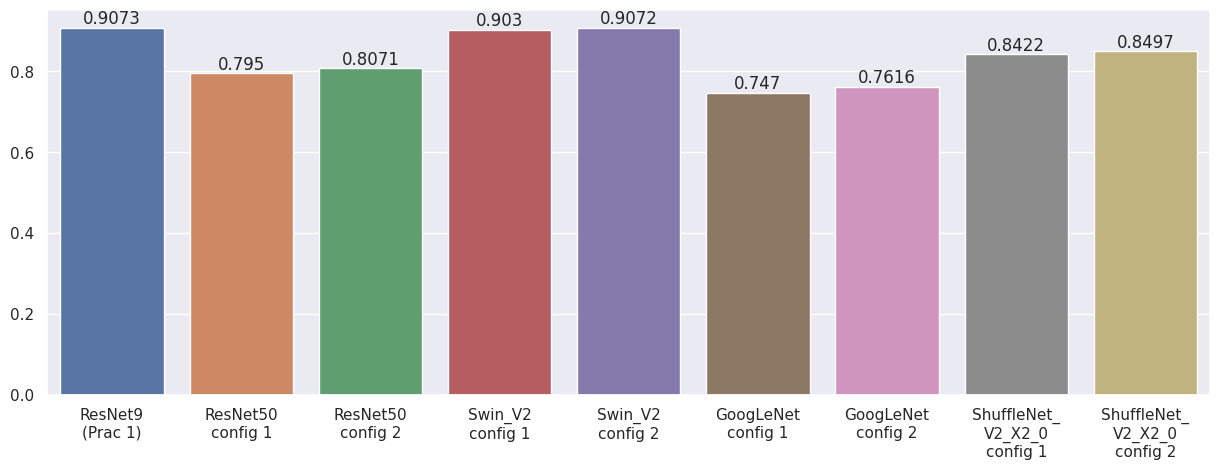

In [87]:
import seaborn
for_gist = {
    "ResNet9\n(Prac 1)": 0.9073,
    "ResNet50\nconfig 1": resnet_first_config_test_acc.item(),
    "ResNet50\nconfig 2": resnet_second_config_test_acc.item(),
    "Swin_V2\nconfig 1": swin_first_config_test_acc.item(),
    "Swin_V2\nconfig 2": swin_second_config_test_acc.item(),
    "GoogLeNet\nconfig 1": googlenet_first_config_test_acc.item(),
    "GoogLeNet\nconfig 2": googlenet_second_config_test_acc.item(),
    "ShuffleNet_\nV2_X2_0\nconfig 1": shufflenet_first_config_test_acc.item(),
    "ShuffleNet_\nV2_X2_0\nconfig 2": shufflenet_second_config_test_acc.item(),
}

seaborn.set(rc={'figure.figsize': (15, 5)})

ax = seaborn.barplot(x=list(for_gist.keys()), y=list(for_gist.values()))
for i in ax.containers:
    ax.bar_label(i,)

## Вывод лучшей модели

In [88]:
best_model_name = max(for_gist, key=lambda key: for_gist[key])
print(f"Best model: {best_model_name}")
print(f"Achived test accuracy: {for_gist[best_model_name]}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {EPOCHS_NUMBER}")
print(f"Batch size: {BATCH_SIZE}")
print("Optimizer - Adam, params from fc layer")

Best model: ResNet9
(Prac 1)
Achived test accuracy: 0.9073
Learning rate: 0.001
Number of epochs: 4
Batch size: 256
Optimizer - Adam, params from fc layer
